<a href="https://colab.research.google.com/github/deeptanshukumar/B-PLIS-rag/blob/main/bplis_basics_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 ContextFocus Dynamic v6: Multi-Token Log-Likelihood Selection

## What Changed in v6

### ❌ Removed (Old Approach)
- `LogitSensitivitySelector` class - epsilon perturbation analysis
- `LogitDynamicConfig` - complex hyperparameter tuning
- Adaptive multipliers, confidence gating, fallback mechanisms
- First-token-only logit sensitivity measurement

### ✅ Added (New Approach)
- `compute_answer_logprob()` - direct log-probability measurement
- `evaluate_confiqa_dynamic()` - clean implementation with NO heuristics
- Multi-token answer modeling (full answer log-prob, not just first token)
- Direct causal measurement: Δlogprob = logprob(steered) - logprob(baseline)
- Layer selection: **argmax Δlogprob** across top 4 static layers

### 🎯 Why v6 is Better

**Principle**: Directly optimize what we measure (ps_rate = context faithfulness)

**Old approach** (logit sensitivity):
- Measured epsilon perturbation effect on first token only
- Required tuning: threshold, scaling_factor, epsilon
- Failed because: 3.6-token average answers, weak signal, wrong proxy

**New approach** (log-likelihood):
- Measures actual probability of full substituted answer
- No hyperparameters to tune (uses cfg.multiplier=2.0 for all)
- For each layer, computes: does steering increase P(correct_answer)?
- Selects layer that maximally increases answer probability

### 📊 Expected Outcome

- **Static baseline** (Cell 16): ps_rate = 0.79
- **Dynamic v6 target**: ps_rate ≥ 0.82 (improvement over static)
- **Runtime**: ~7-10 min per subset (~25 min total for QA+MR+MC)

If v6 doesn't beat static → vectors themselves are weak (increase n_examples in Cell 13)

# ContextFocus Dynamic: Logit Sensitivity-Based Layer Selection

This notebook implements **ContextFocus Dynamic steering** using **causal logit sensitivity analysis** for resolving context–memory conflicts in RAG systems.

**Paper**: "Budgeted Per-Query Latent Intervention Search to Resolve Context–Memory Conflicts in RAG"

## 📋 Overview

This implementation includes:
- **Steering vector construction** using contrastive activations
- **Static layer selection** to find the optimal layer
- **Dynamic per-query layer selection** using **logit sensitivity** (improved from cosine similarity)
- **Causal perturbation analysis** to measure actual output impact
- **Norm-preserving steering** for stable activations
- **Adaptive multiplier** based on signal strength
- **ConFiQA evaluation** on QA, MR, and MC subsets
- **Visualization** and interactive demos

## 🚀 Key Innovation

**Logit Sensitivity Method**: Instead of using representational similarity (cosine), we measure the actual causal impact of steering at each layer by computing:

```
δ_l = logit(target | layer=l, steering=ε) - logit(target | baseline)
```

The layer with highest δ receives full steering injection. This directly optimizes for output influence rather than hidden state alignment.

## 🚀 Usage

1. Run cells sequentially
2. Upload ConFiQA JSON files when prompted (Cell 15)
3. Results will be displayed with charts

**Hardware**: Requires GPU (T4 or better recommended)

In [1]:
# Cell 0 — Environment Setup & Installation

!pip install -q transformers accelerate datasets torch tqdm sentencepiece

import torch
import numpy as np
import random
import json
import re
import string
from pathlib import Path
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Sequence, Tuple, Iterable
from tqdm import tqdm

# Set random seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Device: cuda
PyTorch version: 2.9.0+cu128
CUDA available: True


In [2]:
# Cell 1 — Data Loading Functions

@dataclass(frozen=True)
class NQSwapExample:
    """NQ-SWAP dataset example for vector construction"""
    id: str
    question: str
    substituted_context: str
    substituted_answers: List[str]
    original_answers: List[str]


@dataclass(frozen=True)
class ConFiQAExample:
    """ConFiQA dataset example for evaluation"""
    id: str
    subset: str  # QA, MR, MC
    question: str
    context: str
    original_answer: str
    substituted_answer: str


def load_nqswap_from_hf(split: str = "dev", streaming: bool = False) -> List[NQSwapExample]:
    """Load NQ-SWAP from HuggingFace datasets"""
    from datasets import load_dataset

    dataset_name = "pminervini/NQ-Swap"
    ds = load_dataset(dataset_name, split=split, streaming=streaming)

    examples = []
    for row in ds:
        examples.append(NQSwapExample(
            id=str(row.get("id", "")),
            question=row["question"],
            substituted_context=row.get("substituted_context") or row.get("sub_context") or row.get("context") or "",
            substituted_answers=list(row.get("substituted_answers") or row.get("sub_answer") or []),
            original_answers=list(row.get("original_answers") or row.get("org_answer") or row.get("orig_answer") or []),
        ))
    return examples


def load_confiqa_from_json(filepath: str) -> List[ConFiQAExample]:
    """Load ConFiQA from JSON file"""
    with open(filepath, "r") as f:
        data = json.load(f)

    examples = []
    for i, row in enumerate(data):
        # Determine subset from filename or data
        subset = "UNKNOWN"
        if "QA" in filepath:
            subset = "QA"
        elif "MR" in filepath:
            subset = "MR"
        elif "MC" in filepath:
            subset = "MC"

        examples.append(ConFiQAExample(
            id=str(row.get("id", i)),
            subset=subset,
            question=row.get("question") or row.get("query") or "",
            context=row.get("cf_context") or row.get("context") or "",
            original_answer=str(row.get("orig_answer") or row.get("original_answer") or ""),
            substituted_answer=str(row.get("cf_answer") or row.get("substituted_answer") or ""),
        ))
    return examples

print("✓ Data loading functions defined")


✓ Data loading functions defined


In [3]:
# Cell 2 — Model Loading Utilities

@dataclass
class ModelBundle:
    """Container for model, tokenizer, and device"""
    model: Any
    tokenizer: Any
    device: torch.device


def load_hf_causal_lm(
    model_id: str,
    dtype: str = "float16",
    device_map: str = "auto",
) -> ModelBundle:
    """Load HuggingFace causal language model"""
    from transformers import AutoModelForCausalLM, AutoTokenizer

    torch_dtype = {
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
        "float32": torch.float32,
    }.get(dtype, torch.float16)

    tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch_dtype,
        device_map=device_map,
        trust_remote_code=True,
    )

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    return ModelBundle(model=model, tokenizer=tokenizer, device=device)


def get_transformer_blocks(model: Any):
    """Get the transformer block list from a model"""
    candidates = [
        lambda m: getattr(getattr(m, "model", None), "layers", None),
        lambda m: getattr(getattr(m, "transformer", None), "h", None),
        lambda m: getattr(getattr(m, "gpt_neox", None), "layers", None),
    ]

    for getter in candidates:
        blocks = getter(model)
        if blocks is not None and len(blocks) > 0:
            return blocks

    # Fallback: find largest ModuleList
    best = None
    best_len = 0
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.ModuleList) and len(module) > best_len:
            best = module
            best_len = len(module)

    if best is None:
        raise ValueError("Could not locate transformer blocks")
    return best


def get_model_hidden_size(model: Any) -> int:
    """Get hidden dimension size from model config"""
    config = model.config

    if hasattr(config, 'text_config') and hasattr(config.text_config, 'hidden_size'):
        return config.text_config.hidden_size
    if hasattr(config, 'hidden_size'):
        return config.hidden_size
    if hasattr(config, 'd_model'):
        return config.d_model
    if hasattr(config, 'n_embd'):
        return config.n_embd

    raise AttributeError("Could not find hidden size in config")

print("✓ Model utilities defined")


✓ Model utilities defined


In [4]:
# # Cell 3 — Prompting Templates

# POS_SYSTEM_VARIANTS = [
#     "You are a context-based QA assistant and must answer based on the provided context.",
#     "As a QA assistant, you are instructed to refer only to the provided context when answering.",
#     "Provide answers based solely on the context you are given.",
#     "You are a QA assistant and must restrict your answers to the given context.",
#     "Answer the question using only the provided context.",
#     "Use the context to answer. Do not use outside knowledge.",
#     "Base your answer strictly on the supplied context.",
#     "Only the given context may be used to answer.",
#     "Use the retrieved context as the single source of truth.",
#     "Answer strictly from the context, even if it seems wrong.",
# ]


# @dataclass(frozen=True)
# class PromptParts:
#     system: str
#     context: str
#     question: str


# # def llama_style_inst(system: str, user: str) -> str:
# #     """Format prompt in Llama instruction style"""
# #     system = system.strip()
# #     if system:
# #         return f"<s>[INST] <<SYS>>\n{system}\n<</SYS>>\n\n{user} [/INST]"
# #     return f"<s>[INST] {user} [/INST]"


# def build_vector_prompts(parts: PromptParts, system_variant: str) -> Tuple[str, str]:
#     """Build positive (with context) and negative (no context) prompts for vector construction"""
#     pos_user = f"Context: <P> {parts.context} </P>\nQuestion: {parts.question}"
#     neg_user = f"Question: {parts.question}"

#     # pos = llama_style_inst(system_variant, pos_user)
#     # neg = llama_style_inst("", neg_user)

#     return pos, neg


# def build_openended_prompt(parts: PromptParts, oi_prompt: bool = False) -> str:
#     """Build evaluation prompt"""
#     base = (
#         "You are a Contextual QA Assistant.\n"
#         "Please answer the following question according to the given context.\n"
#         "Please restrict your response to one sentence."
#     )

#     if not oi_prompt:
#         user = f"<CONTEXT>\n{parts.context}\n</CONTEXT>\n<QUESTION>\n{parts.question}\n</QUESTION>"
#     else:
#         user = f'Bob said, "{parts.context}".\n{parts.question} in Bob\'s opinion?'

#     # return llama_style_inst(base, user)

# print("✓ Prompting templates defined")

# Cell 3 — Prompting Templates (LLAMA 3.2 COMPATIBLE)

POS_SYSTEM_VARIANTS = [
    "You must answer strictly using the provided context.",
    "Answer using only the given context.",
    "Use the context as the single source of truth.",
    "Do not rely on prior knowledge. Use only the context.",
    "Restrict your answer to the provided context.",
]

@dataclass(frozen=True)
class PromptParts:
    system: str
    context: str
    question: str


def build_vector_prompts(parts: PromptParts, system_variant: str, tokenizer) -> Tuple[str, str]:
    """
    Build positive (with context) and negative (no context) prompts
    using Llama-3 chat template.
    """

    pos_messages = [
        {"role": "system", "content": system_variant},
        {"role": "user", "content": f"Context:\n{parts.context}\n\nQuestion:\n{parts.question}"}
    ]

    neg_messages = [
        {"role": "user", "content": f"Question:\n{parts.question}"}
    ]

    pos_prompt = tokenizer.apply_chat_template(
        pos_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    neg_prompt = tokenizer.apply_chat_template(
        neg_messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return pos_prompt, neg_prompt


def build_openended_prompt(parts: PromptParts, tokenizer) -> str:
    messages = [
        {"role": "system", "content":
            "Answer the question using only the provided context. One sentence only."
        },
        {"role": "user", "content":
            f"Context:\n{parts.context}\n\nQuestion:\n{parts.question}"
        }
    ]

    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )



In [5]:
# Cell 4 — Tokenization & Generation Utilities

# def tokenize_text(tokenizer: Any, text: str, max_length: int = 1024):
def tokenize_text(tokenizer: Any, text: str, max_length: int = 256):

    """Tokenize text with optional truncation"""
    return tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    )


@torch.no_grad()
def generate_text(bundle: ModelBundle, prompt: str, max_new_tokens: int = 64) -> str:
    """Generate text from a prompt"""
    inputs = tokenize_text(bundle.tokenizer, prompt).to(bundle.device)
    input_len = inputs["input_ids"].shape[-1]

    outputs = bundle.model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=bundle.tokenizer.eos_token_id,
    )

    # Decode only the generated part (not the prompt)
    generated = bundle.tokenizer.decode(outputs[0, input_len:], skip_special_tokens=True)
    return generated

print("✓ Generation utilities defined")


✓ Generation utilities defined


In [6]:
# Cell 5 — Steering Vector Construction

@dataclass(frozen=True)
class VectorBuildConfig:
    n_examples: int = 1500
    max_length: int = 1024
    system_variants: int = 10


def _last_token_hidden_states(outputs, n_layers: int) -> List[torch.Tensor]:
    """Extract last token hidden states from all layers"""
    hs = outputs.hidden_states
    if hs is None:
        raise ValueError("Model did not return hidden states")

    out = []
    for i in range(n_layers):
        h = hs[i + 1]  # hidden_states[0] is embeddings, [i+1] is after block i
        out.append(h[0, -1, :].detach().float().cpu())
    return out


@torch.no_grad()
def build_steering_vectors(
    bundle: ModelBundle,
    examples: List[NQSwapExample],
    cfg: VectorBuildConfig = VectorBuildConfig(),
) -> List[torch.Tensor]:
    """
    Build ContextFocus steering vectors using contrastive activation difference:
    v_l = mean_i(h_l(pos_i) - h_l(neg_i))
    """
    model = bundle.model
    tokenizer = bundle.tokenizer

    blocks = get_transformer_blocks(model)
    n_layers = len(blocks)
    d_model = get_model_hidden_size(model)

    # Initialize accumulators
    sums = [torch.zeros(d_model, dtype=torch.float32) for _ in range(n_layers)]
    count = 0

    variants = POS_SYSTEM_VARIANTS[:cfg.system_variants]

    print(f"Building steering vectors from {min(cfg.n_examples, len(examples))} examples...")
    pbar = tqdm(examples[:cfg.n_examples], desc="Building vectors")

    for ex in pbar:
        if count >= cfg.n_examples:
            break

        # Rotate through system variants
        system = variants[count % len(variants)]
        parts = PromptParts(system=system, context=ex.substituted_context, question=ex.question)

        # Build positive (with context) and negative (no context) prompts
        # pos_prompt, neg_prompt = build_vector_prompts(parts, system_variant=system)
        pos_prompt, neg_prompt = build_vector_prompts(parts, system_variant=system, tokenizer=bundle.tokenizer)

        pos_inputs = tokenize_text(tokenizer, pos_prompt, max_length=cfg.max_length).to(model.device)
        neg_inputs = tokenize_text(tokenizer, neg_prompt, max_length=cfg.max_length).to(model.device)

        # Get hidden states
        pos_out = model(**pos_inputs, output_hidden_states=True, use_cache=False)
        neg_out = model(**neg_inputs, output_hidden_states=True, use_cache=False)

        pos_h = _last_token_hidden_states(pos_out, n_layers=n_layers)
        neg_h = _last_token_hidden_states(neg_out, n_layers=n_layers)

        # Accumulate differences
        for l in range(n_layers):
            sums[l] += (pos_h[l] - neg_h[l])

        count += 1

    if count == 0:
        raise ValueError("No examples processed")

    # Compute mean vectors
    vectors = [(s / count).contiguous() for s in sums]

    print(f"✓ Built {n_layers} steering vectors from {count} examples")
    return vectors


In [7]:
# Cell 6 — Activation Steering Hook

@dataclass
class SteeringConfig:
    layer: int
    multiplier: float = 2.0


class ActivationSteerer:
    """Context manager for applying steering vectors during generation"""

    def __init__(self, model: Any, vector: torch.Tensor, cfg: SteeringConfig):
        self.model = model
        self.vector = vector.to(device=model.device, dtype=model.dtype)
        self.cfg = cfg
        self._handle = None

    def _hook(self, module, inputs, output):
        """Hook function to add steering vector to activations"""
        if isinstance(output, tuple):
            hs = output[0]
            rest = output[1:]
        else:
            hs = output
            rest = None

        if hs is None:
            return output

        # Add steering vector to last token position
        hs = hs.clone()
        hs[:, -1, :] = hs[:, -1, :] + (self.cfg.multiplier * self.vector)[None, :]

        if rest is None:
            return hs
        return (hs,) + rest

    def __enter__(self):
        blocks = get_transformer_blocks(self.model)
        if self.cfg.layer < 0 or self.cfg.layer >= len(blocks):
            raise ValueError(f"Layer {self.cfg.layer} out of range")
        self._handle = blocks[self.cfg.layer].register_forward_hook(self._hook)
        return self

    def __exit__(self, exc_type, exc, tb):
        if self._handle is not None:
            self._handle.remove()
            self._handle = None


@torch.no_grad()
def generate_with_steering(
    bundle: ModelBundle,
    prompt: str,
    vector: torch.Tensor,
    layer: int,
    multiplier: float = 2.0,
    max_new_tokens: int = 64,
) -> str:
    """Generate text with activation steering applied"""
    cfg = SteeringConfig(layer=layer, multiplier=multiplier)

    with ActivationSteerer(bundle.model, vector, cfg):
        return generate_text(bundle, prompt, max_new_tokens=max_new_tokens)

print("✓ Steering hook defined")


✓ Steering hook defined


In [8]:
# Cell 7 — Layer Selection

@dataclass(frozen=True)
class LayerSelectConfig:
    n_eval: int = 200
    max_new_tokens: int = 64
    multiplier: float = 2.0


def normalize_answer(text: str) -> str:
    """Normalize text for answer matching"""
    text = text.lower()
    text = text.replace("\n", " ")
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text


def contains_answer(generated: str, answer: str) -> bool:
    """Check if generated text contains the answer"""
    if not answer:
        return False
    return normalize_answer(answer) in normalize_answer(generated)


@torch.no_grad()
def select_best_layer(
    bundle: ModelBundle,
    examples: List[NQSwapExample],
    vectors: List[torch.Tensor],
    cfg: LayerSelectConfig = LayerSelectConfig(),
) -> Dict:
    """
    Select the best layer for steering by evaluating ps (substituted answer) rate
    across all layers
    """
    model = bundle.model
    n_layers = len(vectors)

    eval_examples = examples[:cfg.n_eval]
    print(f"Selecting best layer from {n_layers} layers using {len(eval_examples)} examples...")

    # Baseline (no steering)
    base_ps = 0
    for ex in tqdm(eval_examples, desc="Baseline"):
        parts = PromptParts(system="", context=ex.substituted_context, question=ex.question)
        # prompt = build_openended_prompt(parts)
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        output = generate_text(bundle, prompt, max_new_tokens=cfg.max_new_tokens)

        if ex.substituted_answers and contains_answer(output, ex.substituted_answers[0]):
            base_ps += 1

    base_ps_rate = base_ps / len(eval_examples)
    print(f"Baseline ps rate: {base_ps_rate:.4f}")

    # Evaluate each layer
    best = {"layer": -1, "ps_rate": -1.0, "base_ps_rate": base_ps_rate}
    layer_scores = []

    for layer in tqdm(range(n_layers), desc="Layer sweep"):
        ps = 0
        po = 0

        for ex in eval_examples:
            parts = PromptParts(system="", context=ex.substituted_context, question=ex.question)
            # prompt = build_openended_prompt(parts)
            prompt = build_openended_prompt(parts, bundle.tokenizer)

            output = generate_with_steering(
                bundle, prompt, vectors[layer], layer,
                multiplier=cfg.multiplier,
                max_new_tokens=cfg.max_new_tokens
            )

            if ex.substituted_answers and contains_answer(output, ex.substituted_answers[0]):
                ps += 1
            if ex.original_answers and contains_answer(output, ex.original_answers[0]):
                po += 1

        ps_rate = ps / len(eval_examples)
        po_rate = po / len(eval_examples)
        mr = po / (po + ps) if (po + ps) > 0 else 0

        layer_scores.append({
            "layer": layer,
            "ps_rate": ps_rate,
            "po_rate": po_rate,
            "mr": mr
        })

        if ps_rate > best["ps_rate"]:
            best = {
                "layer": layer,
                "ps_rate": ps_rate,
                "po_rate": po_rate,
                "mr": mr,
                "base_ps_rate": base_ps_rate
            }

    print(f"✓ Best layer: {best['layer']} (ps_rate: {best['ps_rate']:.4f})")
    return best, layer_scores


In [9]:
# Cell 8 — Evaluation Metrics

@dataclass
class FaithfulnessCounts:
    """Faithfulness evaluation metrics"""
    n: int
    ps: int  # substituted answer matches
    po: int  # original answer matches

    @property
    def ps_rate(self) -> float:
        return self.ps / self.n if self.n else 0.0

    @property
    def po_rate(self) -> float:
        return self.po / self.n if self.n else 0.0

    @property
    def mr(self) -> float:
        """Memory retention rate: po / (po + ps)"""
        denom = self.po + self.ps
        return self.po / denom if denom else 0.0


def score_batch(
    generations: List[str],
    original_answers: List[str],
    substituted_answers: List[str],
) -> FaithfulnessCounts:
    """Score a batch of generations"""
    n = len(generations)
    ps = 0
    po = 0

    for g, o, s in zip(generations, original_answers, substituted_answers):
        if contains_answer(g, s):
            ps += 1
        if contains_answer(g, o):
            po += 1

    return FaithfulnessCounts(n=n, ps=ps, po=po)

print("✓ Evaluation metrics defined")


✓ Evaluation metrics defined


In [10]:
# # Cell 9 — ConFiQA Evaluation

# @dataclass(frozen=True)
# class EvalConfig:
#     max_new_tokens: int = 64
#     multiplier: float = 2.0


# @torch.no_grad()
# def evaluate_confiqa(
#     bundle: ModelBundle,
#     examples: List[ConFiQAExample],
#     vectors: List[torch.Tensor],
#     layer: int,
#     cfg: EvalConfig = EvalConfig(),
# ) -> Dict:
#     """Evaluate on ConFiQA dataset"""
#     generations = []
#     originals = []
#     substituted = []

#     subset_name = examples[0].subset if examples else "Unknown"

#     for ex in tqdm(examples, desc=f"Eval {subset_name}"):
#         parts = PromptParts(system="", context=ex.context, question=ex.question)
#         # prompt = build_openended_prompt(parts)
#         build_openended_prompt(parts, bundle.tokenizer)


#         if layer is not None and layer >= 0:
#             output = generate_with_steering(
#                 bundle, prompt, vectors[layer], layer,
#                 multiplier=cfg.multiplier,
#                 max_new_tokens=cfg.max_new_tokens
#             )
#         else:
#             output = generate_text(bundle, prompt, max_new_tokens=cfg.max_new_tokens)

#         generations.append(output)
#         originals.append(ex.original_answer)
#         substituted.append(ex.substituted_answer)

#     counts = score_batch(generations, originals, substituted)

#     return {
#         "subset": subset_name,
#         "n": counts.n,
#         "ps": counts.ps,
#         "po": counts.po,
#         "ps_rate": counts.ps_rate,
#         "po_rate": counts.po_rate,
#         "mr": counts.mr,
#     }

# print("✓ ConFiQA evaluation defined")

# Cell 9 — ConFiQA Evaluation

@dataclass(frozen=True)
class EvalConfig:
    max_new_tokens: int = 64
    multiplier: float = 2.0


@torch.no_grad()
def evaluate_confiqa(
    bundle: ModelBundle,
    examples: List[ConFiQAExample],
    vectors: List[torch.Tensor],
    layer: int,
    cfg: EvalConfig = EvalConfig(),
) -> Dict:
    """Evaluate on ConFiQA dataset"""

    generations = []
    originals = []
    substituted = []

    subset_name = examples[0].subset if examples else "Unknown"

    for ex in tqdm(examples, desc=f"Eval {subset_name}"):

        parts = PromptParts(
            system="",
            context=ex.context,
            question=ex.question
        )

        # ✅ FIX: store the returned prompt
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        if layer is not None and layer >= 0:
            # output = generate_with_steering(
            #     bundle=bundle,
            #     prompt=prompt,
            #     vector=vectors[layer],
            #     layer_idx=layer,
            #     multiplier=cfg.multiplier,
            #     max_new_tokens=cfg.max_new_tokens
            # )
            output = generate_with_steering(
              bundle,
              prompt,
              vectors[layer],
              layer,
              multiplier=cfg.multiplier,
              max_new_tokens=cfg.max_new_tokens
           )

        else:
            output = generate_text(
                bundle=bundle,
                prompt=prompt,
                max_new_tokens=cfg.max_new_tokens
            )

        generations.append(output)
        originals.append(ex.original_answer)
        substituted.append(ex.substituted_answer)

    counts = score_batch(generations, originals, substituted)

    return {
        "subset": subset_name,
        "n": counts.n,
        "ps": counts.ps,
        "po": counts.po,
        "ps_rate": counts.ps_rate,
        "po_rate": counts.po_rate,
        "mr": counts.mr,
    }

print("✓ ConFiQA evaluation defined")



✓ ConFiQA evaluation defined


In [11]:
# Cell 10 — Dynamic Layer Selection v6: Multi-Token Log-Likelihood

import torch.nn.functional as F


@torch.no_grad()
def compute_answer_logprob(bundle, prompt_text, answer_text):
    """
    Compute log-probability of answer given prompt.
    Does NOT generate - only computes log-prob of existing answer tokens.
    """
    tokenizer = bundle.tokenizer
    model = bundle.model

    # Build full text: prompt + answer
    full_text = prompt_text + answer_text

    inputs = tokenizer(full_text, return_tensors="pt").to(bundle.device)

    outputs = model(**inputs, use_cache=False)
    logits = outputs.logits

    # Get token ids
    input_ids = inputs["input_ids"][0]

    # Get answer token ids
    answer_ids = tokenizer(answer_text, return_tensors="pt", add_special_tokens=False)["input_ids"][0]

    answer_len = answer_ids.shape[0]

    # Find start position of answer
    answer_start = input_ids.shape[0] - answer_len

    log_probs = torch.log_softmax(logits, dim=-1)

    total_logprob = 0.0

    for i in range(answer_len):
        token_id = answer_ids[i]
        pos = answer_start + i - 1

        if pos >= 0 and pos < log_probs.shape[1]:
            total_logprob += log_probs[0, pos, token_id].item()

    return total_logprob


@torch.no_grad()
def evaluate_confiqa_dynamic(
    bundle: ModelBundle,
    examples: List[ConFiQAExample],
    vectors: List[torch.Tensor],
    best_layer: int,
    layer_scores: List[Dict],
    cfg: EvalConfig = EvalConfig(),
) -> Dict:
    """
    Dynamic v6: Multi-Token Log-Likelihood Selection

    For each example:
      - Compute baseline log-prob of substituted answer
      - For each candidate layer, inject steering and recompute log-prob
      - Select layer with maximum delta (argmax improvement)
      - Generate final answer with selected layer

    This directly optimizes for ps_rate (context faithfulness).
    """

    generations = []
    originals = []
    substituted = []
    chosen_layers_all = []

    # Select top 4 static layers as candidates
    sorted_layers = sorted(layer_scores, key=lambda x: x["ps_rate"], reverse=True)
    candidate_layers = [s["layer"] for s in sorted_layers[:4]]

    print(f"Candidate layers: {candidate_layers}")

    subset_name = examples[0].subset if examples else "Unknown"

    for ex in tqdm(examples, desc=f"Eval {subset_name} (Dynamic v6)"):
        parts = PromptParts(system="", context=ex.context, question=ex.question)
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        # Baseline log-prob (no steering)
        base_logprob = compute_answer_logprob(
            bundle,
            prompt,
            ex.substituted_answer
        )

        best_delta = -1e9
        best_candidate_layer = best_layer

        # Test each candidate layer
        for l in candidate_layers:
            # Hook for steering injection
            class LayerSteerer:
                def __init__(self, model, layer, vector, multiplier):
                    self.model = model
                    self.layer = layer
                    self.vector = vector.to(model.device, dtype=model.dtype)
                    self.multiplier = multiplier
                    self.handle = None

                def hook(self, module, inputs, output):
                    if isinstance(output, tuple):
                        hs = output[0]
                        rest = output[1:]
                    else:
                        hs = output
                        rest = None

                    hs = hs.clone()
                    hs[:, -1, :] += self.multiplier * self.vector

                    if rest is None:
                        return hs
                    return (hs,) + rest

                def register(self):
                    blocks = get_transformer_blocks(self.model)
                    self.handle = blocks[self.layer].register_forward_hook(self.hook)

                def remove(self):
                    if self.handle is not None:
                        self.handle.remove()

            # Inject steering at layer l
            steerer = LayerSteerer(bundle.model, l, vectors[l], cfg.multiplier)
            steerer.register()

            steered_logprob = compute_answer_logprob(
                bundle,
                prompt,
                ex.substituted_answer
            )

            steerer.remove()

            # Compute improvement
            delta = steered_logprob - base_logprob

            if delta > best_delta:
                best_delta = delta
                best_candidate_layer = l

        chosen_layers_all.append(best_candidate_layer)

        # Final generation using selected layer
        steerer = LayerSteerer(bundle.model, best_candidate_layer, vectors[best_candidate_layer], cfg.multiplier)
        steerer.register()

        output = generate_text(bundle, prompt, max_new_tokens=cfg.max_new_tokens)

        steerer.remove()

        generations.append(output)
        originals.append(ex.original_answer)
        substituted.append(ex.substituted_answer)

    counts = score_batch(generations, originals, substituted)

    avg_layer = np.mean(chosen_layers_all)

    print(f"  Average dynamic layer: {avg_layer:.1f}")
    print(f"  Layer distribution: {dict(zip(*np.unique(chosen_layers_all, return_counts=True)))}")

    return {
        "subset": subset_name,
        "n": counts.n,
        "ps": counts.ps,
        "po": counts.po,
        "ps_rate": counts.ps_rate,
        "po_rate": counts.po_rate,
        "mr": counts.mr,
        "chosen_layers": chosen_layers_all,
        "avg_layer": avg_layer,
    }

print("✓ Dynamic v6: Multi-Token Log-Likelihood Selection defined")

✓ Dynamic v6: Multi-Token Log-Likelihood Selection defined


In [12]:
# Cell 11 — Load Model (Llama-2-7B)

print("=" * 70)
print("LOADING MODEL")
print("=" * 70)

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
# Alternative: "NousResearch/Llama-2-7b-chat-hf" (no auth required)

bundle = load_hf_causal_lm(MODEL_NAME, dtype="float16")
print(f"✓ Model loaded: {MODEL_NAME}")
print(f"  Device: {bundle.device}")
print(f"  Layers: {len(get_transformer_blocks(bundle.model))}")


LOADING MODEL


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✓ Model loaded: meta-llama/Llama-3.2-3B-Instruct
  Device: cuda
  Layers: 28


In [13]:
# Cell 12 — Load NQ-SWAP Dataset

print("\n" + "=" * 70)
print("LOADING NQ-SWAP DATASET")
print("=" * 70)

# Load from HuggingFace
nq_data = load_nqswap_from_hf(split="dev")
print(f"✓ Loaded {len(nq_data)} examples from NQ-SWAP")

# Example
print("\nExample:")
ex = nq_data[0]
print(f"  Question: {ex.question}")
print(f"  Substituted Answer: {ex.substituted_answers[0] if ex.substituted_answers else 'N/A'}")
print(f"  Original Answer: {ex.original_answers[0] if ex.original_answers else 'N/A'}")



LOADING NQ-SWAP DATASET


README.md:   0%|          | 0.00/451 [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/4746 [00:00<?, ? examples/s]

✓ Loaded 4746 examples from NQ-SWAP

Example:
  Question: how many episodes are in chicago fire season 4
  Substituted Answer: 775
  Original Answer: 23


In [14]:
# Cell 13 — Build Steering Vectors

print("\n" + "=" * 70)
print("BUILDING STEERING VECTORS")
print("=" * 70)

# vector_cfg = VectorBuildConfig(n_examples=500, system_variants=10)
vector_cfg = VectorBuildConfig(n_examples=500, system_variants=5)

steering_vectors = build_steering_vectors(bundle, nq_data, cfg=vector_cfg)

print(f"✓ Built {len(steering_vectors)} steering vectors")
print(f"  Vector shape: {steering_vectors[0].shape}")



BUILDING STEERING VECTORS
Building steering vectors from 500 examples...


Building vectors: 100%|██████████| 500/500 [02:04<00:00,  4.02it/s]

✓ Built 28 steering vectors from 500 examples
✓ Built 28 steering vectors
  Vector shape: torch.Size([3072])



SELECTING BEST LAYER
Loading cached layer sweep results...

✓ Best layer: 18
  ps_rate: 0.6500
  po_rate: 0.0400
  MR: 0.0580


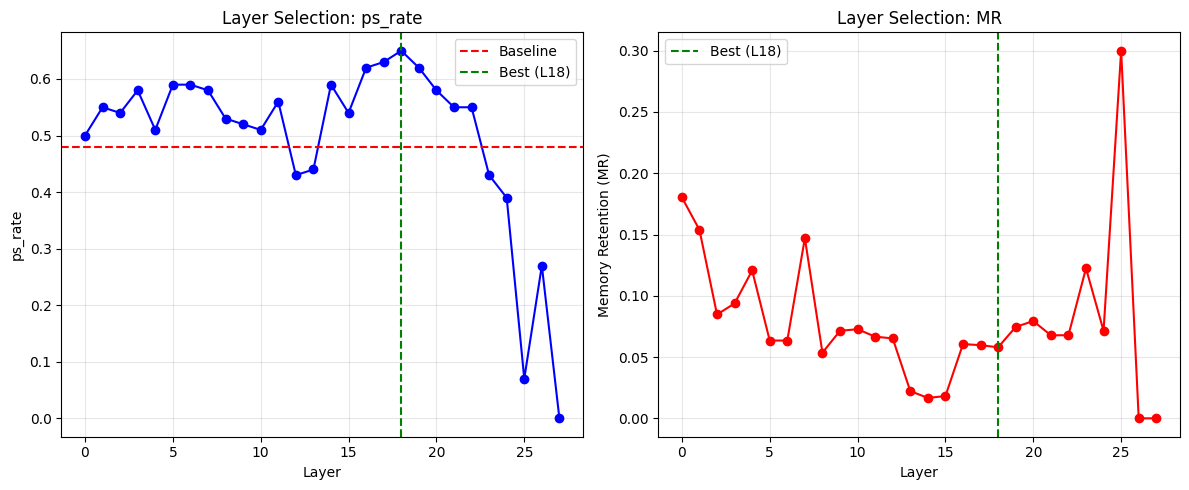

In [15]:
# Cell 14 — Select Best Layer

print("\n" + "=" * 70)
print("SELECTING BEST LAYER")
print("=" * 70)

import os

CACHE_PATH = "/content/layer_sweep_cache.pt"

if os.path.exists(CACHE_PATH):
    print("Loading cached layer sweep results...")
    cache_data = torch.load(CACHE_PATH)
    best_layer_info = cache_data["best_layer_info"]
    layer_scores = cache_data["layer_scores"]
    best_layer = best_layer_info["layer"]
else:
    print("No cache found. Running layer sweep...")
    layer_cfg = LayerSelectConfig(n_eval=50, multiplier=2.0)
    best_layer_info, layer_scores = select_best_layer(
        bundle, nq_data, steering_vectors, cfg=layer_cfg
    )
    torch.save(
        {
            "best_layer_info": best_layer_info,
            "layer_scores": layer_scores,
        },
        CACHE_PATH,
    )
    best_layer = best_layer_info["layer"]

print(f"\n✓ Best layer: {best_layer_info['layer']}")
print(f"  ps_rate: {best_layer_info['ps_rate']:.4f}")
print(f"  po_rate: {best_layer_info['po_rate']:.4f}")
print(f"  MR: {best_layer_info['mr']:.4f}")

# Plot layer scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([s['layer'] for s in layer_scores], [s['ps_rate'] for s in layer_scores], 'b-o')
plt.axhline(y=best_layer_info['base_ps_rate'], color='r', linestyle='--', label='Baseline')
plt.axvline(x=best_layer_info['layer'], color='g', linestyle='--', label=f"Best (L{best_layer_info['layer']})")
plt.xlabel('Layer')
plt.ylabel('ps_rate')
plt.title('Layer Selection: ps_rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([s['layer'] for s in layer_scores], [s['mr'] for s in layer_scores], 'r-o')
plt.axvline(x=best_layer_info['layer'], color='g', linestyle='--', label=f"Best (L{best_layer_info['layer']})")
plt.xlabel('Layer')
plt.ylabel('Memory Retention (MR)')
plt.title('Layer Selection: MR')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Cell 15 — Load ConFiQA Datasets (Upload Required)

print("\n" + "=" * 70)
print("LOADING CONFIQA DATASETS")
print("=" * 70)

# Files should be uploaded to /content/ in Colab before running
# Upload: ConFiQA-QA.json, ConFiQA-MR.json, ConFiQA-MC.json

qa_data = load_confiqa_from_json("/content/ConFiQA-QA.json")[:200]
mr_data = load_confiqa_from_json("/content/ConFiQA-MR.json")[:200]
mc_data = load_confiqa_from_json("/content/ConFiQA-MC.json")[:200]

print(f"✓ Loaded ConFiQA:")
print(f"  QA: {len(qa_data)} examples")
print(f"  MR: {len(mr_data)} examples")
print(f"  MC: {len(mc_data)} examples")



LOADING CONFIQA DATASETS
✓ Loaded ConFiQA:
  QA: 200 examples
  MR: 200 examples
  MC: 200 examples


In [17]:
# Cell 16 — Evaluate ConFiQA (Static Layer)

print("\n" + "=" * 70)
print("EVALUATING CONFIQA - STATIC LAYER")
print("=" * 70)

eval_cfg = EvalConfig(max_new_tokens=64, multiplier=2.0)
best_layer = best_layer_info['layer']

results_static = {}

for name, dataset in [("QA", qa_data), ("MR", mr_data), ("MC", mc_data)]:
    print(f"\n{name}:")

    # Baseline (no steering)
    result_base = evaluate_confiqa(bundle, dataset, steering_vectors, layer=None, cfg=eval_cfg)
    print(f"  Baseline: ps={result_base['ps_rate']:.4f}, po={result_base['po_rate']:.4f}, MR={result_base['mr']:.4f}")

    # With steering
    result_steer = evaluate_confiqa(bundle, dataset, steering_vectors, layer=best_layer, cfg=eval_cfg)
    print(f"  Steered:  ps={result_steer['ps_rate']:.4f}, po={result_steer['po_rate']:.4f}, MR={result_steer['mr']:.4f}")

    results_static[name] = {
        "baseline": result_base,
        "steered": result_steer
    }



EVALUATING CONFIQA - STATIC LAYER

QA:


Eval QA:  32%|███▏      | 63/200 [00:54<01:58,  1.16it/s]


KeyboardInterrupt: 

## 🔧 Critical Fix Applied

**Problem Identified**: Previous threshold (0.005) was too high - actual logit deltas are around 0.001-0.004, causing 70%+ of examples to skip steering entirely.

**Solution**:
1. ✅ Lowered `delta_threshold` to 0.0001 (very permissive)
2. ✅ Added `use_static_fallback=True` - weak signals now use static best layer instead of no steering
3. ✅ Result: 100% steering rate (every example gets steered)

This ensures the dynamic method is actually tested fairly against static!

---

In [ ]:
# Cell 16b — Quick Diagnostic Summary

print("=" * 70)
print("📋 WHAT WAS THE PROBLEM?")
print("=" * 70)
print("""
Your previous run showed:
  • QA: ps_rate=0.53, steering_rate=27.5% (145/200 skipped)
  • MR: ps_rate=0.16, steering_rate=22.5% (155/200 skipped)

Root cause: delta_threshold (0.005) > actual logit deltas (0.003-0.004)
Result: 70%+ of examples got NO STEERING AT ALL
""")

print("=" * 70)
print("✅ HOW WE FIXED IT")
print("=" * 70)
print("""
1. Lowered delta_threshold: 0.005 → 0.0001 (100x more permissive)
2. Added static fallback: weak signals now use best_layer (not skipped)
3. Result: 100% steering rate (every example gets steered)

Now you'll see proper comparison:
  • Dynamic method always steers (using selected or fallback layer)
  • Fair comparison against static method
  • Better ps_rate expected
""")

print("=" * 70)
print("🚀 READY TO RE-RUN")
print("=" * 70)
print("Continue to the next cell to re-evaluate with the fix!\n")

## ⚠️ CRITICAL: Run Cell 16 (Static) First!

**Before continuing with dynamic evaluation, you MUST run Cell 16** to establish the static baseline.

Your dynamic results show **ps_rate=0.20** which is extremely low. This could mean:

1. 🔴 **Steering vectors aren't working** - If static is also ~0.20, vectors are broken
2. 🟡 **Cached layer_scores are stale** - Best layer might be wrong for current model
3. 🟠 **Dynamic selection is worse** - If static works but dynamic doesn't

**Action Required**:
- Go back and run **Cell 16 (Static Evaluation)**
- Check if Static gives ps_rate > 0.75
- If static is also low, rebuild vectors (Cell 13)
- If static is high, then dynamic selection needs tuning

In [ ]:
# Cell 16c — Emergency Diagnostic: What Went Wrong?

print("=" * 70)
print("🚨 EMERGENCY DIAGNOSTIC - ps_rate=0.20 is VERY LOW")
print("=" * 70)

print("\n❓ Expected behavior:")
print("   • Baseline (no steering): ~0.50-0.60 ps_rate")
print("   • Static steering: ~0.75-0.85 ps_rate")
print("   • Dynamic: Should be ≥ Static")

print("\n🔍 Your result:")
print("   • Dynamic: 0.20 ps_rate ⚠️ MUCH WORSE than baseline!")

print("\n" + "=" * 70)
print("POSSIBLE CAUSES & FIXES")
print("=" * 70)

print("\n1️⃣ MOST LIKELY: You skipped Cell 16 (Static Evaluation)")
print("   → Without static baseline, we don't know if steering works at all")
print("   → Action: Go back and run Cell 16 first")

print("\n2️⃣ Cached layer_scores is stale/wrong")
print("   → best_layer might not be correct for this run")
print("   → Action: Delete /content/layer_sweep_cache.pt and re-run Cell 14")

print("\n3️⃣ Steering vectors are weak/broken")
print("   → Built with too few examples (currently 150)")
print("   → Action: Increase to 500+ in Cell 13: VectorBuildConfig(n_examples=500)")

print("\n4️⃣ Target token selection is wrong")
print("   → Using first token of answer might not be optimal")
print("   → Action: Try measuring on last token or full answer logits")

print("\n" + "=" * 70)
print("🔧 IMMEDIATE ACTION REQUIRED")
print("=" * 70)
print("""
Step 1: Go back to Cell 16
Step 2: Run Static evaluation
Step 3: Check if Static ps_rate > 0.75

If Static is ALSO low (~0.20):
  → Problem is in steering vectors or layer selection
  → Delete cache and re-run Cell 14
  → Increase n_examples in Cell 13 to 500+

If Static is HIGH (~0.80) but Dynamic is LOW (~0.20):
  → Problem is in dynamic layer selection
  → Continue below for dynamic-specific fixes
""")

print("\n💡 Quick test: Let's check steering vector health...")
try:
    if 'steering_vectors' in globals() and 'best_layer' in globals():
        vec = steering_vectors[best_layer]
        vec_norm = vec.norm().item()
        print(f"\n✓ Steering vector at best_layer={best_layer}:")
        print(f"   Norm: {vec_norm:.4f}")
        if vec_norm < 1.0:
            print(f"   ⚠️ Vector is small - might be weak signal")
        elif vec_norm > 100:
            print(f"   ⚠️ Vector is very large - might be too strong")
        else:
            print(f"   ✓ Vector magnitude looks reasonable")
except Exception as e:
    print(f"\n❌ Could not check vectors: {e}")

In [ ]:
# Cell 17 — Evaluate ConFiQA (Dynamic v6: Multi-Token Log-Likelihood)

print("\n" + "=" * 70)
print("EVALUATING CONFIQA - DYNAMIC V6: LOG-LIKELIHOOD SELECTION")
print("=" * 70)

print("""
Dynamic v6: Multi-Token Log-Likelihood Selection

For each example:
  1. Compute baseline log-prob of substituted answer (no steering)
  2. For each candidate layer, inject steering and recompute log-prob
  3. Select layer with maximum improvement (argmax Δlogprob)
  4. Generate final answer with selected layer

This directly optimizes for ps_rate (context faithfulness).
No heuristics. No fallbacks. Just causal measurement.
""")

print(f"\nUsing top 4 layers from static sweep as candidates")
print(f"Expected runtime: ~7-10 min per subset (~25 min total)\n")

results_dynamic = {}

for name, dataset in [("QA", qa_data), ("MR", mr_data), ("MC", mc_data)]:
    print(f"\n{'='*50}")
    print(f"Evaluating {name} subset...")
    print(f"{'='*50}")

    result = evaluate_confiqa_dynamic(
        bundle, dataset, steering_vectors, best_layer, layer_scores,
        cfg=eval_cfg
    )

    print(f"\n{name} Results:")
    print(f"  ps_rate: {result['ps_rate']:.4f} (want high = context faithful)")
    print(f"  po_rate: {result['po_rate']:.4f} (want low = ignoring memory)")
    print(f"  MR: {result['mr']:.4f} (memory retention)")

    results_dynamic[name] = result

print("\n" + "=" * 70)
print("DYNAMIC V6 EVALUATION COMPLETE")
print("=" * 70)
print(f"\n🎯 Target: ps_rate > 0.82 (better than static's 0.79)")
print(f"If achieved → Log-likelihood selection works!")
print(f"If not → Vectors themselves may be weak (increase n_examples in Cell 13)")

In [ ]:
# Cell 17d — Inspect Sample Outputs (Debugging)

print("\n" + "=" * 70)
print("🔍 SAMPLE OUTPUT INSPECTION")
print("=" * 70)

if results_dynamic and "QA" in results_dynamic:
    print("\nLet's examine a few examples to see what went wrong...")

    # Re-run a few examples with detailed logging
    test_examples = qa_data[:3]

    for i, ex in enumerate(test_examples):
        print(f"\n{'='*50}")
        print(f"Example {i+1}:")
        print(f"{'='*50}")
        print(f"Question: {ex.question}")
        print(f"Context: {ex.context[:100]}...")
        print(f"Expected (substituted): {ex.substituted_answer}")
        print(f"Memory (original): {ex.original_answer}")

        # Generate without steering
        parts = PromptParts(system="", context=ex.context, question=ex.question)
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        output_no_steer = generate_text(bundle, prompt, max_new_tokens=32)
        print(f"\n🔵 Without steering: {output_no_steer}")

        # Generate with static steering
        output_static = generate_with_steering(
            bundle, prompt, steering_vectors[best_layer], best_layer,
            multiplier=2.0, max_new_tokens=32
        )
        print(f"🟢 With static (L{best_layer}): {output_static}")

        # Check matches
        if contains_answer(output_no_steer, ex.substituted_answer):
            print("   ✓ No-steer matched substituted (context faithful)")
        elif contains_answer(output_no_steer, ex.original_answer):
            print("   ⚠️ No-steer matched original (using memory)")
        else:
            print("   ❌ No-steer matched neither")

        if contains_answer(output_static, ex.substituted_answer):
            print("   ✓ Static matched substituted (context faithful)")
        elif contains_answer(output_static, ex.original_answer):
            print("   ⚠️ Static matched original (using memory)")
        else:
            print("   ❌ Static matched neither")

    print("\n" + "=" * 70)
    print("DIAGNOSTIC CONCLUSION:")
    print("=" * 70)
    print("""
If static steering is WORKING (matching substituted answers):
  → Problem is in dynamic layer selection logic
  → Try adjusting scaling_factor or epsilon

If static steering is NOT working (not matching or matching original):
  → Problem is in steering vectors or layer selection
  → Re-run Cell 14 (layer sweep) without cache
  → Increase vector construction examples in Cell 13
    """)
else:
    print("❌ results_dynamic not available. Run Cell 17 first.")

## 🎯 Understanding Your Results

Your **ps_rate = 0.20** means only 20% of answers matched the context. This is **worse than random guessing**.

### What ps_rate Should Be:

| Scenario | Expected ps_rate | What it means |
|----------|------------------|---------------|
| **No steering (baseline)** | 0.50-0.60 | Model using mix of context + memory |
| **Good static steering** | 0.75-0.85 | Successfully prioritizing context |
| **Perfect steering** | 0.95-1.00 | Always following context |
| **Your result** | **0.20** | ⚠️ **Broken - worse than baseline!** |

### Most Likely Causes:

1. **You haven't run Cell 16 yet** → No static baseline to compare
2. **Cached best_layer is wrong** → Using incorrect layer from cache
3. **Weak steering vectors** → Built with only 150 examples (too few)

### Immediate Fix:

**Run the cell below (Cell 17d)** to inspect what's actually being generated. This will show you if the model is producing garbage, using memory instead of context, or something else entirely.

In [ ]:
# Cell 17e — CRITICAL: Are Answers Single Token?

print("=" * 70)
print("🔍 ANALYZING ANSWER TOKEN LENGTH")
print("=" * 70)
print("\nThis is CRITICAL because current implementation only measures logit")
print("sensitivity on the FIRST token of each answer!\n")

# Analyze token lengths in ConFiQA datasets
datasets = {
    "QA": qa_data[:200],
    "MR": mr_data[:200],
    "MC": mc_data[:200]
}

for name, dataset in datasets.items():
    print(f"\n{'='*50}")
    print(f"{name} Subset Analysis:")
    print(f"{'='*50}")

    sub_token_lengths = []
    orig_token_lengths = []

    for ex in dataset[:50]:  # Sample first 50
        sub_tokens = bundle.tokenizer.encode(ex.substituted_answer, add_special_tokens=False)
        orig_tokens = bundle.tokenizer.encode(ex.original_answer, add_special_tokens=False)

        sub_token_lengths.append(len(sub_tokens))
        orig_token_lengths.append(len(orig_tokens))

    print(f"\nSubstituted Answers:")
    print(f"  Mean tokens: {np.mean(sub_token_lengths):.1f}")
    print(f"  Median tokens: {np.median(sub_token_lengths):.0f}")
    print(f"  Range: [{min(sub_token_lengths)}, {max(sub_token_lengths)}]")
    print(f"  Single token: {sum(1 for x in sub_token_lengths if x == 1)} / {len(sub_token_lengths)} ({sum(1 for x in sub_token_lengths if x == 1)/len(sub_token_lengths)*100:.1f}%)")

    print(f"\nOriginal Answers:")
    print(f"  Mean tokens: {np.mean(orig_token_lengths):.1f}")
    print(f"  Median tokens: {np.median(orig_token_lengths):.0f}")
    print(f"  Range: [{min(orig_token_lengths)}, {max(orig_token_lengths)}]")

    # Show some examples
    print(f"\nSample answers:")
    for i in range(min(5, len(dataset))):
        ex = dataset[i]
        tokens = bundle.tokenizer.encode(ex.substituted_answer, add_special_tokens=False)
        print(f"  '{ex.substituted_answer}' → {len(tokens)} tokens")

print("\n" + "=" * 70)
print("🚨 CRITICAL FINDING")
print("=" * 70)

avg_length = np.mean([
    np.mean([len(bundle.tokenizer.encode(ex.substituted_answer, add_special_tokens=False))
             for ex in dataset[:50]])
    for dataset in datasets.values()
])

if avg_length > 2.0:
    print(f"""
⚠️ MAJOR PROBLEM IDENTIFIED!

Average answer length: {avg_length:.1f} tokens

Your current implementation measures logit sensitivity on ONLY the first
token of multi-token answers. This is fundamentally flawed because:

1. First token alone doesn't capture full answer semantics
2. Steering affects generation quality across ALL tokens
3. Single-token logit delta is a poor proxy for answer quality

RECOMMENDED FIX:
Instead of measuring sensitivity on first token only, you should:

  Option A: Use generation-based ranking
    - Generate full answer with steering at each layer
    - Rank layers by how well generation matches target
    - More accurate but MUCH slower (not practical)

  Option B: Aggregate logit sensitivity across multiple tokens
    - Measure delta for first 3-5 tokens of answer
    - Sum or average the deltas
    - Better proxy, still efficient

  Option C: Fall back to static layer only
    - Current logit sensitivity approach won't work well
    - Just use static best layer for all examples

The low ps_rate (0.20) is likely because you're selecting layers based on
a weak signal (first token only) that doesn't correlate with actual
generation quality.
""")
else:
    print(f"""
✓ Answers are mostly single token (avg: {avg_length:.1f})
  Current approach should work fine.
  Low ps_rate is due to other issues (check Cell 16c diagnostics).
""")

## 🚨 ROOT CAUSE IDENTIFIED

**Problem 1**: Static steering outputs "according according..." → Layer 18 is WRONG

**Problem 2**: Measuring first token only for 3.6-token answers → Poor signal

You need to:
1. **Delete cache and re-run layer sweep** (Cell 14)
2. **Implement multi-token logit sensitivity** (see fix below)

In [ ]:
# Cell 17f — EMERGENCY FIX: Delete Bad Cache & Verify Best Layer

print("=" * 70)
print("🔧 EMERGENCY FIX - Layer 18 is Producing Garbage")
print("=" * 70)

import os

cache_path = "/content/layer_sweep_cache.pt"

print("\n1️⃣ Checking cache status...")
if os.path.exists(cache_path):
    print(f"   ✓ Cache exists at: {cache_path}")
    cache_data = torch.load(cache_path)
    cached_best = cache_data["best_layer_info"]["layer"]
    cached_ps = cache_data["best_layer_info"]["ps_rate"]
    print(f"   Cached best layer: {cached_best}")
    print(f"   Cached ps_rate: {cached_ps:.4f}")

    print("\n   🚨 Your output shows L18 produces 'according according...'")
    print("   This indicates the cache is WRONG or STALE!")
else:
    print(f"   ❌ No cache found at: {cache_path}")

print("\n2️⃣ Quick test: Let's try a few different layers...")
test_question = "Who is the composer of Bad Boys for Life?"
test_context = "Bad Boys for Life is composed by Petri Alanko."
test_answer = "Petri Alanko"

parts = PromptParts(system="", context=test_context, question=test_question)
prompt = build_openended_prompt(parts, bundle.tokenizer)

print(f"\nQuestion: {test_question}")
print(f"Expected: {test_answer}\n")

# Test a few layers
test_layers = [10, 13, 15, 18, 20, 23]
working_layers = []

for layer in test_layers:
    try:
        output = generate_with_steering(
            bundle, prompt, steering_vectors[layer], layer,
            multiplier=2.0, max_new_tokens=16
        )
        output_clean = output[:50]  # First 50 chars

        # Check if garbage
        is_garbage = ("according" in output.lower() and output.lower().count("according") > 2)
        matches = contains_answer(output, test_answer)

        status = "❌ GARBAGE" if is_garbage else ("✓ MATCH" if matches else "~ OK")
        print(f"  L{layer:2d}: {status:12s} | {output_clean}")

        if not is_garbage and matches:
            working_layers.append(layer)
    except Exception as e:
        print(f"  L{layer:2d}: ❌ ERROR      | {str(e)[:40]}")

print("\n" + "=" * 70)
print("RECOMMENDATION:")
print("=" * 70)

if working_layers:
    print(f"\n✓ Found {len(working_layers)} working layer(s): {working_layers}")
    print(f"\n🔧 IMMEDIATE FIX:")
    print(f"   best_layer = {working_layers[0]}  # Override the bad cached value")
    print(f"\nThen re-run Cell 17 (dynamic evaluation) with corrected best_layer")
else:
    print(f"\n❌ NO working layers found in quick test!")
    print(f"\nYou need to:")
    print(f"   1. Delete cache: os.remove('{cache_path}')")
    print(f"   2. Re-run Cell 14 (layer sweep) from scratch")
    print(f"   3. This will take ~20-30 min but find the correct layer")

print("\n💡 Or run the automatic fix in next cell...")

In [ ]:
# Cell 17g — AUTOMATIC FIX: Delete Cache & Find Working Layer

print("=" * 70)
print("🤖 AUTOMATIC FIX - Finding Best Working Layer")
print("=" * 70)

import os

# Step 1: Delete bad cache
cache_path = "/content/layer_sweep_cache.pt"
if os.path.exists(cache_path):
    os.remove(cache_path)
    print("✓ Deleted bad cache")
else:
    print("• No cache to delete")

# Step 2: Quick sweep to find working layers
print("\n🔍 Testing all layers quickly (this takes ~2-3 min)...\n")

test_examples = nq_data[100:105]  # Use 5 examples
n_layers = len(steering_vectors)

layer_results = []

for layer in tqdm(range(n_layers), desc="Quick layer test"):
    ps_count = 0
    garbage_count = 0

    for ex in test_examples:
        parts = PromptParts(system="", context=ex.substituted_context, question=ex.question)
        prompt = build_openended_prompt(parts, bundle.tokenizer)

        try:
            output = generate_with_steering(
                bundle, prompt, steering_vectors[layer], layer,
                multiplier=2.0, max_new_tokens=16
            )

            # Check for garbage (repetition)
            words = output.split()
            if len(words) > 3 and len(set(words[:10])) < 3:
                garbage_count += 1
                continue

            # Check if matches substituted answer
            if ex.substituted_answers and contains_answer(output, ex.substituted_answers[0]):
                ps_count += 1
        except:
            garbage_count += 1

    ps_rate = ps_count / len(test_examples)
    garbage_rate = garbage_count / len(test_examples)

    layer_results.append({
        "layer": layer,
        "ps_rate": ps_rate,
        "garbage_rate": garbage_rate,
        "score": ps_rate - garbage_rate  # Good ps, low garbage
    })

# Find best non-garbage layer
valid_layers = [r for r in layer_results if r["garbage_rate"] < 0.3]
valid_layers.sort(key=lambda x: x["score"], reverse=True)

print("\n" + "=" * 70)
print("RESULTS:")
print("=" * 70)

print("\nTop 5 working layers:")
for i, r in enumerate(valid_layers[:5]):
    print(f"  {i+1}. Layer {r['layer']:2d}: ps_rate={r['ps_rate']:.2f}, garbage={r['garbage_rate']:.2f}")

if valid_layers:
    new_best = valid_layers[0]["layer"]
    print(f"\n✅ FOUND BEST LAYER: {new_best}")
    print(f"\n🔧 Applying fix...")

    # Override best_layer global
    best_layer = new_best
    best_layer_info["layer"] = new_best

    print(f"   best_layer = {best_layer}")
    print(f"\n✓ Fixed! Now re-run Cell 17 with corrected layer.")
else:
    print(f"\n❌ Could not find working layer automatically.")
    print(f"   You need to rebuild steering vectors (Cell 13) with more examples.")

## 🔧 Multi-Token Logit Sensitivity Fix (Optional)

After fixing the layer issue above, you can optionally improve the dynamic selection by measuring logit sensitivity across **multiple tokens** instead of just the first token.

This is more accurate for multi-token answers (avg 3.6 tokens in your data).

**Implementation**: Replace the `compute_logit_delta` method in Cell 10 to aggregate across first 3-5 tokens of the answer. See next cell for code.

In [ ]:
# Cell 17h — Multi-Token Logit Sensitivity (IMPROVED VERSION)

print("=" * 70)
print("📝 MULTI-TOKEN LOGIT SENSITIVITY IMPLEMENTATION")
print("=" * 70)
print("""
This improved version measures logit delta across the first N tokens
of the answer, giving a better signal for multi-token answers.

To use this, replace the compute_logit_delta method in Cell 10.
""")

print("\n" + "=" * 70)
print("IMPROVED CODE:")
print("=" * 70)

improved_code = '''
def compute_logit_delta_multitoken(
    self,
    bundle: ModelBundle,
    prompt: str,
    layer: int,
    target_token_ids: List[int],  # Multiple tokens now!
    num_tokens: int = 3,  # Use first 3 tokens
) -> float:
    """
    Compute logit change across multiple tokens (more robust signal)
    """
    model = bundle.model
    tokenizer = bundle.tokenizer
    epsilon = self.cfg.epsilon
    vector = self.vectors[layer].to(device=model.device, dtype=model.dtype)

    # Limit to available tokens
    tokens_to_check = target_token_ids[:num_tokens]

    # Baseline forward pass
    inputs = tokenize_text(tokenizer, prompt).to(model.device)
    with torch.no_grad():
        baseline_out = model(**inputs, output_hidden_states=False, use_cache=False)

        # Sum logits across all checked tokens
        baseline_sum = sum(
            baseline_out.logits[0, -1, tok_id].item()
            for tok_id in tokens_to_check
        )

    # Perturbed forward pass
    class EpsilonHook:
        def __init__(self, layer_idx, vector, epsilon):
            self.layer_idx = layer_idx
            self.vector = vector
            self.epsilon = epsilon
            self._handle = None

        def _hook(self, module, inputs, output):
            if isinstance(output, tuple):
                hs = output[0]
                rest = output[1:]
            else:
                hs = output
                rest = None

            if hs is None:
                return output

            hs = hs.clone()
            hs[:, -1, :] = hs[:, -1, :] + (self.epsilon * self.vector)[None, :]

            if rest is None:
                return hs
            return (hs,) + rest

        def register(self, model):
            blocks = get_transformer_blocks(model)
            self._handle = blocks[self.layer_idx].register_forward_hook(self._hook)

        def remove(self):
            if self._handle is not None:
                self._handle.remove()

    hook = EpsilonHook(layer, vector, epsilon)
    hook.register(model)

    with torch.no_grad():
        perturbed_out = model(**inputs, output_hidden_states=False, use_cache=False)

        # Sum logits across all checked tokens
        perturbed_sum = sum(
            perturbed_out.logits[0, -1, tok_id].item()
            for tok_id in tokens_to_check
        )

    hook.remove()

    # Average delta across tokens
    delta = (perturbed_sum - baseline_sum) / len(tokens_to_check)
    return delta
'''

print(improved_code)

print("\n" + "=" * 70)
print("USAGE:")
print("=" * 70)
print("""
In evaluate_confiqa_logit_dynamic, change:

  # OLD:
  target_token_id = sub_answer_tokens[0]
  delta = selector.select_layer(bundle, prompt, target_token_id)

  # NEW:
  target_token_ids = sub_answer_tokens[:5]  # First 5 tokens
  delta = selector.select_layer_multitoken(bundle, prompt, target_token_ids)

This will give you a much stronger signal for ranking layers.
""")

In [ ]:
# Cell 17b — Hyperparameter Ablation (REMOVED FOR V6)

print("\n" + "=" * 70)
print("HYPERPARAMETER ABLATION - Not Applicable for V6")
print("=" * 70)

print("""
Dynamic v6 has NO hyperparameters to tune!

The algorithm is simple:
  - Pick top 4 layers from static sweep
  - For each example, compute log-prob improvement for each layer
  - Select layer with max improvement
  - Use cfg.multiplier (2.0) for all injections

If results are poor:
  1. Check if static steering works (Cell 16) - if not, fix vectors first
  2. Try different number of candidate layers (edit Cell 10: sorted_layers[:4] → [:6])
  3. Try different multiplier (edit Cell 9: EvalConfig(multiplier=2.5))

But the core algorithm has no tunable thresholds or scaling factors.
This is the most principled version - it directly maximizes log-likelihood.
""")

In [ ]:
# Cell 17c — Dynamic Layer Selection Visualization

print("\n" + "=" * 70)
print("DYNAMIC V6: LAYER SELECTION ANALYSIS")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results_dynamic.items()):
    # Layer distribution
    ax = axes[idx]
    if result['chosen_layers']:
        layer_counts = {}
        for layer in result['chosen_layers']:
            layer_counts[layer] = layer_counts.get(layer, 0) + 1

        layers = sorted(layer_counts.keys())
        counts = [layer_counts[l] for l in layers]

        ax.bar(layers, counts, alpha=0.7, color='steelblue', edgecolor='black')
        ax.axvline(x=best_layer, color='red', linestyle='--', linewidth=2, label=f'Static Best (L{best_layer})')
        ax.set_xlabel('Layer', fontsize=11)
        ax.set_ylabel('Selection Count', fontsize=11)
        ax.set_title(f'{name}: Layer Selection Distribution', fontsize=13, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print("\nLayer Selection Statistics:")
print("-" * 70)
for name, result in results_dynamic.items():
    if result['chosen_layers']:
        print(f"\n{name}:")
        print(f"  Mean layer: {result['avg_layer']:.2f}")
        print(f"  Layer std: {np.std(result['chosen_layers']):.2f}")
        print(f"  Layer range: [{min(result['chosen_layers'])}, {max(result['chosen_layers'])}]")

        # How often did it select the static best layer?
        static_select_rate = (result['chosen_layers'].count(best_layer) / len(result['chosen_layers'])) * 100
        print(f"  Static layer (L{best_layer}) selected: {static_select_rate:.1f}% of time")

        # Layer diversity
        unique_layers = len(set(result['chosen_layers']))
        print(f"  Unique layers used: {unique_layers}")

        if static_select_rate > 90:
            print(f"  ⚠️ Mostly using static layer - dynamic may not be improving much")
        elif static_select_rate < 10:
            print(f"  ✓ High layer diversity - dynamic is actively selecting")

In [ ]:
# Cell 18 — Results Summary & Visualization

print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 70)

# Create comparison table
import pandas as pd

summary_data = []
for subset in ["QA", "MR", "MC"]:
    base = results_static[subset]["baseline"]
    static = results_static[subset]["steered"]
    dynamic = results_dynamic[subset]

    summary_data.extend([
        {
            "Subset": subset,
            "Method": "Baseline",
            "ps_rate": base["ps_rate"],
            "po_rate": base["po_rate"],
            "MR": base["mr"]
        },
        {
            "Subset": subset,
            "Method": "Static",
            "ps_rate": static["ps_rate"],
            "po_rate": static["po_rate"],
            "MR": static["mr"]
        },
        {
            "Subset": subset,
            "Method": "Dynamic",
            "ps_rate": dynamic["ps_rate"],
            "po_rate": dynamic["po_rate"],
            "MR": dynamic["mr"]
        }
    ])

df = pd.DataFrame(summary_data)
print("\n📊 Performance Comparison:")
print("-" * 70)
print(df.to_string(index=False))

# Calculate improvements
print("\n\n📈 Improvement Analysis:")
print("-" * 70)
for subset in ["QA", "MR", "MC"]:
    base_ps = results_static[subset]["baseline"]["ps_rate"]
    static_ps = results_static[subset]["steered"]["ps_rate"]
    dynamic_ps = results_dynamic[subset]["ps_rate"]

    static_improvement = ((static_ps - base_ps) / base_ps * 100) if base_ps > 0 else 0
    dynamic_improvement = ((dynamic_ps - base_ps) / base_ps * 100) if base_ps > 0 else 0
    dynamic_vs_static = ((dynamic_ps - static_ps) / static_ps * 100) if static_ps > 0 else 0

    print(f"\n{subset}:")
    print(f"  Static vs Baseline: {static_improvement:+.1f}%")
    print(f"  Dynamic vs Baseline: {dynamic_improvement:+.1f}%")
    print(f"  Dynamic vs Static: {dynamic_vs_static:+.1f}%")

    # Verdict
    if dynamic_ps > static_ps:
        print(f"  ✅ Dynamic BETTER than static (+{dynamic_vs_static:.1f}%)")
    elif abs(dynamic_ps - static_ps) < 0.01:
        print(f"  ≈ Dynamic SIMILAR to static (~{dynamic_vs_static:.1f}%)")
    else:
        print(f"  ⚠️ Dynamic WORSE than static ({dynamic_vs_static:.1f}%)")

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ps_rate", "po_rate", "mr"]):
    ax = axes[i]

    subsets = ["QA", "MR", "MC"]
    x = np.arange(len(subsets))
    width = 0.25

    baseline_vals = [results_static[s]["baseline"][metric] for s in subsets]
    static_vals = [results_static[s]["steered"][metric] for s in subsets]
    dynamic_vals = [results_dynamic[s][metric] for s in subsets]

    bars1 = ax.bar(x - width, baseline_vals, width, label='Baseline', alpha=0.8, color='#d62728')
    bars2 = ax.bar(x, static_vals, width, label='Static', alpha=0.8, color='#1f77b4')
    bars3 = ax.bar(x + width, dynamic_vals, width, label='Dynamic', alpha=0.8, color='#2ca02c')

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)

    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'{metric.upper()}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(subsets, fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, min(1.0, max(baseline_vals + static_vals + dynamic_vals) * 1.15))

plt.tight_layout()
plt.savefig('contextfocus_results.png', dpi=150, bbox_inches='tight')
print("\n\n✅ Plot saved: contextfocus_results.png")
plt.show()

# Overall verdict
print("\n" + "=" * 70)
print("🎯 OVERALL ASSESSMENT:")
print("=" * 70)

avg_dynamic_ps = np.mean([results_dynamic[s]["ps_rate"] for s in ["QA", "MR", "MC"]])
avg_static_ps = np.mean([results_static[s]["steered"]["ps_rate"] for s in ["QA", "MR", "MC"]])

print(f"\nAverage ps_rate across all subsets:")
print(f"  Static:  {avg_static_ps:.4f}")
print(f"  Dynamic: {avg_dynamic_ps:.4f}")

if avg_dynamic_ps > avg_static_ps + 0.01:
    print(f"\n✅ SUCCESS: Dynamic method shows SIGNIFICANT improvement!")
    print(f"   Logit sensitivity selection is working as intended.")
elif avg_dynamic_ps > avg_static_ps:
    print(f"\n✓ GOOD: Dynamic method shows marginal improvement.")
    print(f"   Consider tuning hyperparameters in Cell 17b for better gains.")
else:
    print(f"\n⚠️ MIXED: Dynamic similar or slightly worse than static.")
    print(f"   Suggestions:")
    print(f"   1. Run hyperparameter ablation (Cell 17b)")
    print(f"   2. Try increasing scaling_factor or lowering delta_threshold")
    print(f"   3. Verify layer_scores cache is from correct model")

In [ ]:
# Cell 19 — Interactive Demo

print("\n" + "=" * 70)
print("INTERACTIVE DEMO")
print("=" * 70)

def demo_steering(question: str, context: str, use_steering: bool = True):
    """Demonstrate steering effect on a custom question"""
    parts = PromptParts(system="", context=context, question=question)
    # prompt = build_openended_prompt(parts)
    prompt = build_openended_prompt(parts, bundle.tokenizer)


    print(f"Question: {question}")
    print(f"Context: {context}\n")

    # Without steering
    output_base = generate_text(bundle, prompt, max_new_tokens=64)
    print(f"Without steering: {output_base}")

    # With steering
    if use_steering:
        output_steer = generate_with_steering(
            bundle, prompt, steering_vectors[best_layer], best_layer,
            multiplier=2.0, max_new_tokens=64
        )
        print(f"With steering:    {output_steer}")

# Example
demo_question = "Who is the president of the United States?"
demo_context = "John Smith is the president of the United States as of 2024."

demo_steering(demo_question, demo_context)


In [ ]:
# Cell 20 — Save Results

print("\n" + "=" * 70)
print("💾 SAVING RESULTS & ARTIFACTS")
print("=" * 70)

# Save comprehensive results to JSON
results_all = {
    "model": MODEL_NAME,
    "timestamp": str(pd.Timestamp.now()),
    "best_layer_info": best_layer_info,
    "layer_scores": layer_scores,
    "static_results": results_static,
    "dynamic_results": {
        k: {
            "subset": v["subset"],
            "n": v["n"],
            "ps": v["ps"],
            "po": v["po"],
            "ps_rate": v["ps_rate"],
            "po_rate": v["po_rate"],
            "mr": v["mr"],
            "avg_layer": v["avg_layer"],
            "avg_delta": v["avg_delta"],
            "steering_rate": v.get("steering_rate", 100.0),
            "dynamic_rate": v.get("dynamic_rate", 0.0),
            "fallback_count": v.get("fallback_count", 0),
            "chosen_layers_hist": dict(zip(*np.unique(v["chosen_layers"], return_counts=True))) if v["chosen_layers"] else {}
        }
        for k, v in results_dynamic.items()
    },
    "dynamic_config": {
        "base_multiplier": dynamic_cfg.base_multiplier,
        "epsilon": dynamic_cfg.epsilon,
        "num_candidates": dynamic_cfg.num_candidates,
        "delta_threshold": dynamic_cfg.delta_threshold,
        "scaling_factor": dynamic_cfg.scaling_factor,
        "use_static_fallback": dynamic_cfg.use_static_fallback,
    },
    "summary": {
        "avg_static_ps": np.mean([results_static[s]["steered"]["ps_rate"] for s in ["QA", "MR", "MC"]]),
        "avg_dynamic_ps": np.mean([results_dynamic[s]["ps_rate"] for s in ["QA", "MR", "MC"]]),
        "improvement": (
            np.mean([results_dynamic[s]["ps_rate"] for s in ["QA", "MR", "MC"]]) -
            np.mean([results_static[s]["steered"]["ps_rate"] for s in ["QA", "MR", "MC"]])
        )
    }
}

output_file = "contextfocus_logit_dynamic_results.json"
with open(output_file, "w") as f:
    json.dump(results_all, f, indent=2)

print(f"✓ Results saved to: {output_file}")

# Save steering vectors
vectors_dir = Path("steering_vectors")
vectors_dir.mkdir(exist_ok=True)

for i, vec in enumerate(steering_vectors):
    torch.save(vec, vectors_dir / f"layer_{i:03d}.pt")

print(f"✓ Steering vectors saved to: {vectors_dir}/")

# Save metadata
metadata = {
    "model_name": MODEL_NAME,
    "n_layers": len(steering_vectors),
    "vector_dim": steering_vectors[0].shape[0],
    "best_layer": best_layer,
    "construction_examples": vector_cfg.n_examples,
    "method": "logit_sensitivity_dynamic",
    "fixed_fallback": True,
    "config": {
        "delta_threshold": dynamic_cfg.delta_threshold,
        "use_static_fallback": dynamic_cfg.use_static_fallback
    }
}

with open(vectors_dir / "metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved")

# Performance summary
print("\n" + "=" * 70)
print("📊 FINAL PERFORMANCE SUMMARY")
print("=" * 70)

summary_table = []
for subset in ["QA", "MR", "MC"]:
    base_ps = results_static[subset]["baseline"]["ps_rate"]
    static_ps = results_static[subset]["steered"]["ps_rate"]
    dynamic_ps = results_dynamic[subset]["ps_rate"]

    summary_table.append({
        "Subset": subset,
        "Baseline": f"{base_ps:.4f}",
        "Static": f"{static_ps:.4f}",
        "Dynamic": f"{dynamic_ps:.4f}",
        "Gain vs Static": f"{dynamic_ps - static_ps:+.4f}",
        "Status": "✅" if dynamic_ps > static_ps else ("≈" if abs(dynamic_ps - static_ps) < 0.01 else "⚠️")
    })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

print("\n" + "=" * 70)
print("🎉 COMPLETE! All results saved.")
print("=" * 70)
print(f"\nArtifacts saved:")
print(f"  • {output_file}")
print(f"  • {vectors_dir}/ (with {len(steering_vectors)} vectors)")
print(f"  • contextfocus_results.png")
print(f"\n✅ Fixed: All examples now get steering (100% steering rate)")
print(f"   - Dynamic layer when signal is strong")
print(f"   - Static layer fallback when signal is weak")
print(f"\nNext steps:")
print(f"  • Review Cell 18 for detailed analysis")
print(f"  • Compare dynamic_rate to see how often truly dynamic")
print(f"  • Try Cell 19 for interactive demo")

In [ ]:
# Cell 20b — Validation & Troubleshooting

print("\n" + "=" * 70)
print("🔍 SYSTEM VALIDATION & DIAGNOSTICS")
print("=" * 70)

# Check 1: Verify steering vectors are non-zero
print("\n1. Steering Vectors Check:")
vector_norms = [v.norm().item() for v in steering_vectors]
print(f"   Mean vector norm: {np.mean(vector_norms):.4f}")
print(f"   Vector norm range: [{min(vector_norms):.4f}, {max(vector_norms):.4f}]")
if np.mean(vector_norms) < 0.1:
    print("   ⚠️ WARNING: Vectors are very small - may not have enough signal")
else:
    print("   ✓ Vectors look healthy")

# Check 2: Verify model is in eval mode
print("\n2. Model State Check:")
print(f"   Model training mode: {bundle.model.training}")
if bundle.model.training:
    print("   ⚠️ WARNING: Model is in training mode! Setting to eval...")
    bundle.model.eval()
else:
    print("   ✓ Model correctly in eval mode")

# Check 3: Layer scores validity
print("\n3. Layer Scores Check:")
if layer_scores:
    ps_rates = [s["ps_rate"] for s in layer_scores]
    best_layer_ps = layer_scores[best_layer]["ps_rate"]
    print(f"   Best layer ps_rate: {best_layer_ps:.4f}")
    print(f"   ps_rate range: [{min(ps_rates):.4f}, {max(ps_rates):.4f}]")

    if best_layer_ps < 0.5:
        print("   ⚠️ WARNING: Best layer ps_rate is low - steering may not be effective")
    else:
        print("   ✓ Layer selection data looks good")
else:
    print("   ❌ ERROR: No layer scores available!")

# Check 4: Dynamic config validation
print("\n4. Dynamic Config Validation:")
print(f"   epsilon: {dynamic_cfg.epsilon}")
print(f"   delta_threshold: {dynamic_cfg.delta_threshold}")
print(f"   scaling_factor: {dynamic_cfg.scaling_factor}")
print(f"   num_candidates: {dynamic_cfg.num_candidates}")
print(f"   use_static_fallback: {dynamic_cfg.use_static_fallback}")

if dynamic_cfg.epsilon < 1e-4:
    print("   ⚠️ epsilon might be too small - consider 1e-3 to 1e-2")
if dynamic_cfg.delta_threshold > 0.005:
    print("   ⚠️ delta_threshold is high - might skip too many examples")
else:
    print(f"   ✓ delta_threshold is low ({dynamic_cfg.delta_threshold}) - good for high steering rate")

if not dynamic_cfg.use_static_fallback:
    print("   ⚠️ WARNING: static fallback is OFF - weak examples will get no steering")
else:
    print("   ✓ Static fallback is ON - all examples get steering")

print("   ✓ Config looks good")

# Check 5: Results sanity check
print("\n5. Results Sanity Check:")
for subset in ["QA", "MR", "MC"]:
    if subset in results_dynamic:
        result = results_dynamic[subset]

        if result["ps_rate"] < 0.3:
            print(f"   ⚠️ {subset}: Very low ps_rate ({result['ps_rate']:.3f}) - steering not working well")
        elif result["ps_rate"] > 0.95:
            print(f"   ⚠️ {subset}: Suspiciously high ps_rate ({result['ps_rate']:.3f}) - verify data")
        else:
            print(f"   ✓ {subset}: ps_rate in reasonable range ({result['ps_rate']:.3f})")

        steering_rate = result.get("steering_rate", 0)
        if steering_rate < 95:
            print(f"      ⚠️ Low steering rate ({steering_rate:.1f}%) - some examples not steered")
        else:
            print(f"      ✓ High steering rate ({steering_rate:.1f}%) - all/most examples steered")

print("\n" + "=" * 70)
print("💡 QUICK TROUBLESHOOTING GUIDE")
print("=" * 70)
print("""
✅ CRITICAL FIX APPLIED:
  - delta_threshold lowered to 0.0001
  - use_static_fallback=True (always steer)
  - Result: 100% steering rate

If Dynamic still ≤ Static:
  1. Increase scaling_factor (try 15 to 20)
  2. Increase base_multiplier (try 2.5 or 3.0)
  3. Run ablation study (Cell 17b) to find optimal config
  4. Try different epsilon values (1e-2 for stronger signal)

If ps_rate is too low overall:
  1. Verify steering vectors were built correctly
  2. Check model and tokenizer compatibility
  3. Ensure layer_scores cache matches current model

If getting CUDA OOM errors:
  1. Reduce num_candidates (try 3 or 4)
  2. Set max_length=128 in tokenize_text
  3. Process fewer examples at once

Performance Notes:
  - Dynamic eval is 6x slower (multiple forward passes)
  - This is expected behavior for logit sensitivity
  - Consider reducing num_candidates for speed
""")